In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; print('Tensorflow version:',tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import regularizers

Tensorflow version: 2.8.1


In [2]:
print('Available devices:', tf.config.list_physical_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2*1024)]
    )

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-02 10:59:34.093095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 10:59:34.123737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 10:59:34.123955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
DIRECTORY = 'dataset'
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 16
COLOR_MODE='grayscale'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE    
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="training"
    , seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="validation"
    , seed=123
)

Found 5481 files belonging to 8 classes.
Using 4385 files for training.


2022-11-02 10:59:34.327179: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 10:59:34.327496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 10:59:34.327703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 10:59:34.327859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Found 5481 files belonging to 8 classes.
Using 1096 files for validation.


In [4]:
class_names = train_dataset.class_names
print(class_names)

['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']


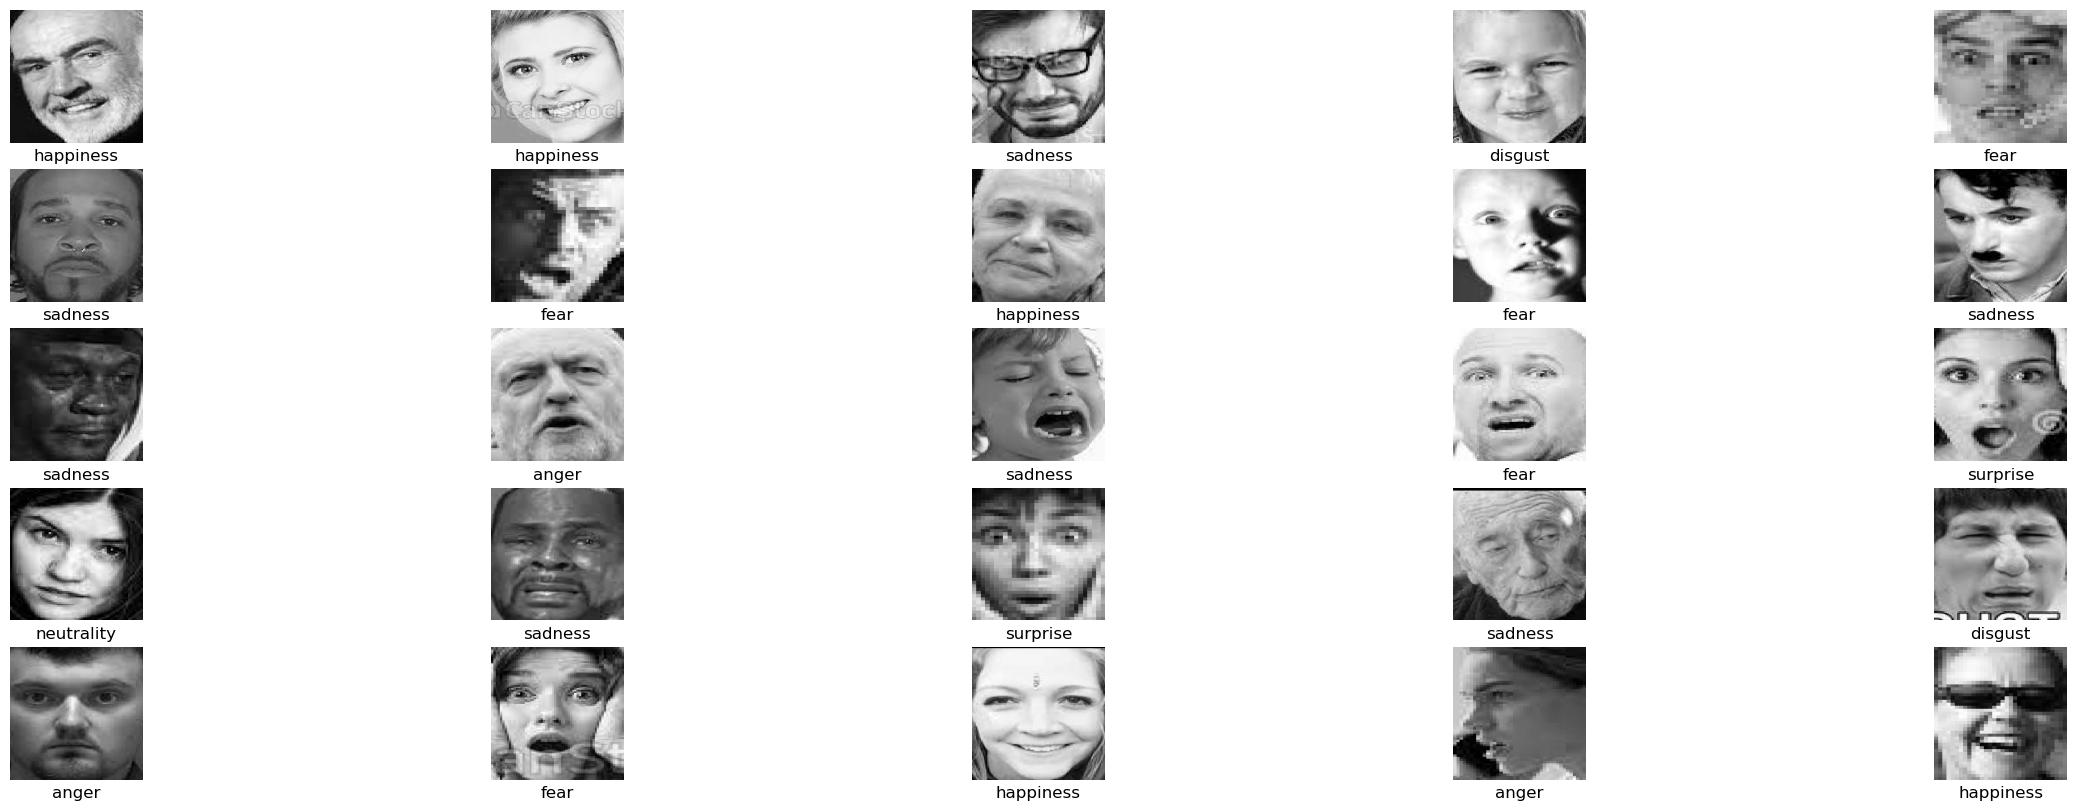

In [5]:
plt.figure(figsize=(30, 10))
for i, ( image, label ) in zip(range(25), train_dataset.unbatch()):    
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image.numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[label], y=-0.20)
    plt.axis("off")
plt.show()

In [6]:
validation_dataset_cardinality = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_dataset_cardinality // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 69
Number of test batches: 13


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Use data augmentation
data_augmentation = tf.keras.Sequential(
    [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        , tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05)
        , tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1)
    ]
)

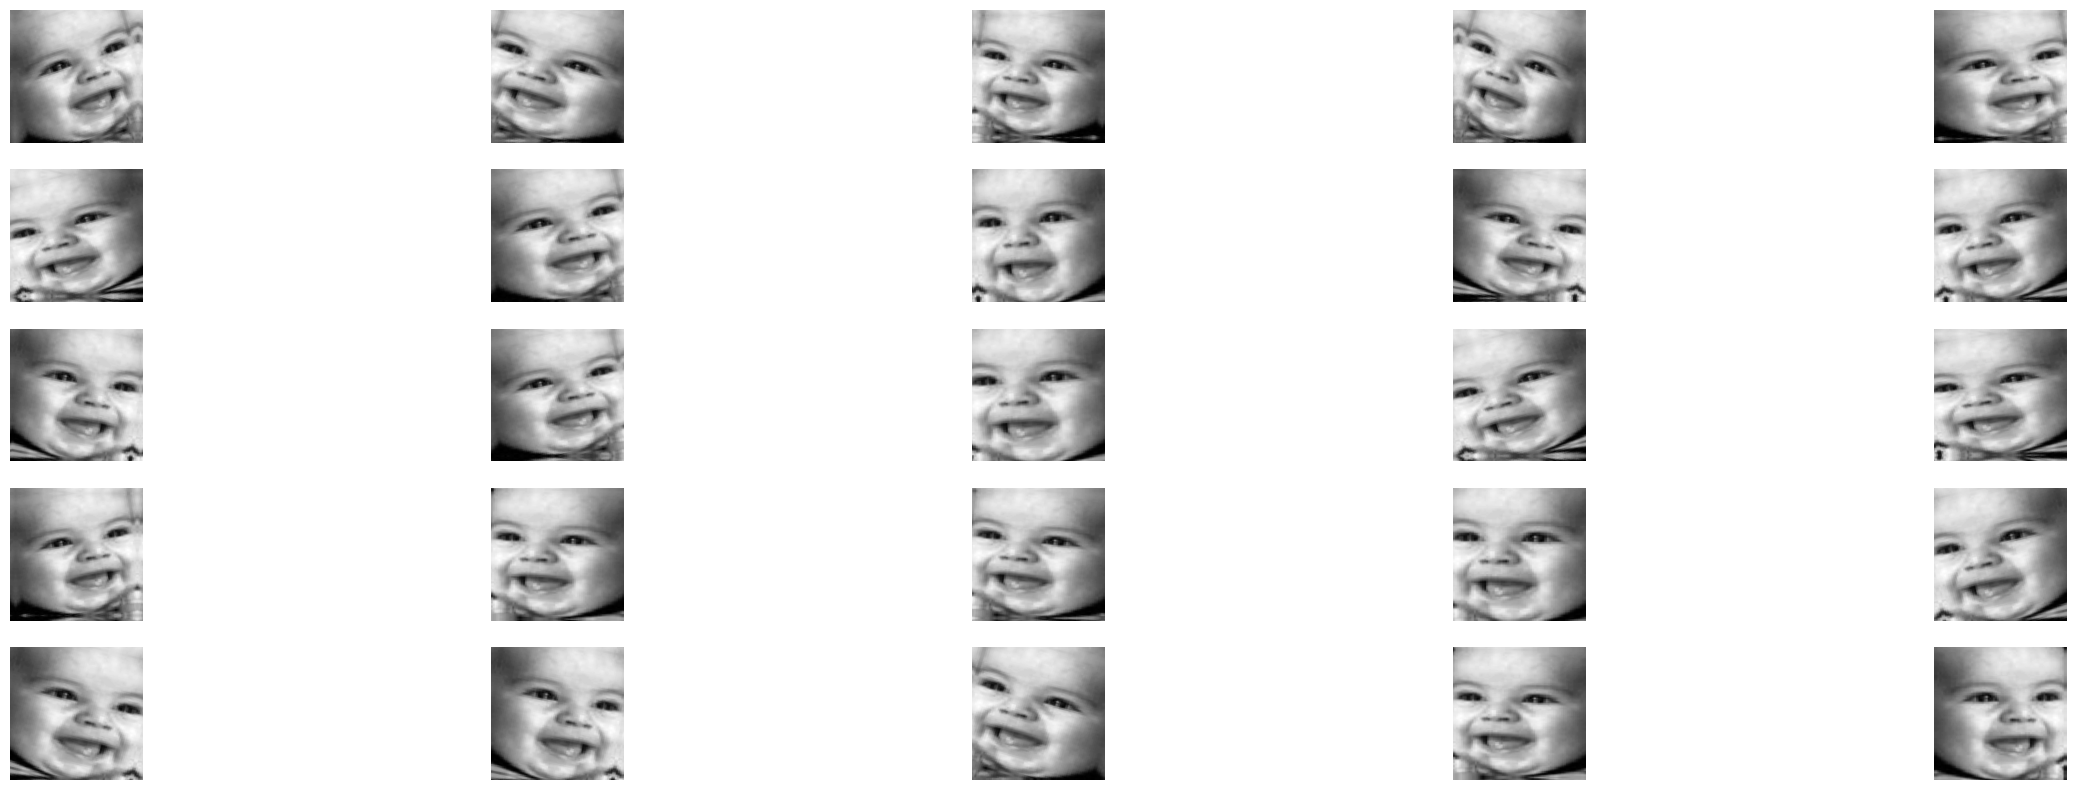

In [8]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(30, 10))
    image = images[0]    
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0].numpy() / 255, cmap='gray')
        plt.axis('off')
plt.show()

In [9]:
# MODEL
INPUT_SHAPE = image.shape
#print('INPUT SHAPE: ',  INPUT_SHAPE)
base_model = tf.keras.Sequential()

base_model.add(layers.Input(shape=INPUT_SHAPE))

base_model.add(layers.Conv2D(filters=15, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV01'))
base_model.add(layers.BatchNormalization(name='BNOR01'))
base_model.add(layers.Activation('relu', name='RELU01'))
base_model.add(layers.Dropout(0.1, name='DROP01'))

base_model.add(layers.MaxPool2D(pool_size=(2,2), name='MP0102'))

base_model.add(layers.Conv2D(filters=30, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV02'))
base_model.add(layers.BatchNormalization(name='BNOR02'))
base_model.add(layers.Activation('relu', name='RELU02'))
base_model.add(layers.Dropout(0.1, name='DROP02'))

base_model.add(layers.MaxPool2D(pool_size=(2,2), name='MP0203'))

base_model.add(layers.Conv2D(filters=60, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV03'))
base_model.add(layers.BatchNormalization(name='BNOR03'))
base_model.add(layers.Activation('relu', name='RELU03'))
base_model.add(layers.Dropout(0.1, name='DROP03'))

base_model.add(layers.MaxPool2D(pool_size=(2,2), name='MP0304'))

base_model.add(layers.Conv2D(filters=120, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV04'))
base_model.add(layers.BatchNormalization(name='BNOR04'))
base_model.add(layers.Activation('relu', name='RELU04'))
base_model.add(layers.Dropout(0.1, name='DROP04'))

base_model.add(layers.Flatten(name='FLAT01'))

base_model.add(layers.Dense(9, name='DENS01'))
base_model.add(layers.Dropout(0.1, name='DROP05'))

base_model.add(layers.Activation('softmax', name='SOFT01'))

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV01 (Conv2D)             (None, 224, 224, 15)      150       
                                                                 
 BNOR01 (BatchNormalization)  (None, 224, 224, 15)     60        
                                                                 
 RELU01 (Activation)         (None, 224, 224, 15)      0         
                                                                 
 DROP01 (Dropout)            (None, 224, 224, 15)      0         
                                                                 
 MP0102 (MaxPooling2D)       (None, 112, 112, 15)      0         
                                                                 
 CONV02 (Conv2D)             (None, 112, 112, 30)      4080      
                                                                 
 BNOR02 (BatchNormalization)  (None, 112, 112, 30)    

In [10]:
inputs = layers.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
outputs = base_model(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 sequential_1 (Sequential)   (None, 9)                 933039    
                                                                 
Total params: 933,039
Trainable params: 932,589
Non-trainable params: 450
_________________________________________________________________


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

2022-11-02 10:59:38.136329: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-11-02 10:59:38.561478: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


(16, 9)


In [13]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# Train the model
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

 1/69 [..............................] - ETA: 18s - loss: 13.4463 - accuracy: 0.0000e+00

/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


69/69 [==============================] - 3s 38ms/step - loss: 13.5516 - accuracy: 0.0748
initial loss: 13.55
initial accuracy: 0.07


In [15]:
initial_epochs = 50
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
275/275 [==============================] - 41s 141ms/step - loss: 2.3995 - accuracy: 0.2725 - val_loss: 1.9172 - val_accuracy: 0.3276
Epoch 2/50
275/275 [==============================] - 39s 142ms/step - loss: 2.0367 - accuracy: 0.3398 - val_loss: 2.1380 - val_accuracy: 0.2400
Epoch 3/50
275/275 [==============================] - 37s 134ms/step - loss: 1.8849 - accuracy: 0.3713 - val_loss: 1.8341 - val_accuracy: 0.3376
Epoch 4/50
275/275 [==============================] - 37s 135ms/step - loss: 1.8382 - accuracy: 0.3900 - val_loss: 1.7442 - val_accuracy: 0.3796
Epoch 5/50
275/275 [==============================] - 37s 136ms/step - loss: 1.7636 - accuracy: 0.3975 - val_loss: 1.6701 - val_accuracy: 0.4234
Epoch 6/50
275/275 [==============================] - 38s 138ms/step - loss: 1.7066 - accuracy: 0.4214 - val_loss: 1.7089 - val_accuracy: 0.3878
Epoch 7/50
275/275 [==============================] - 36s 132ms/step - loss: 1.5975 - accuracy: 0.4351 - val_loss: 1.5570 - val_ac

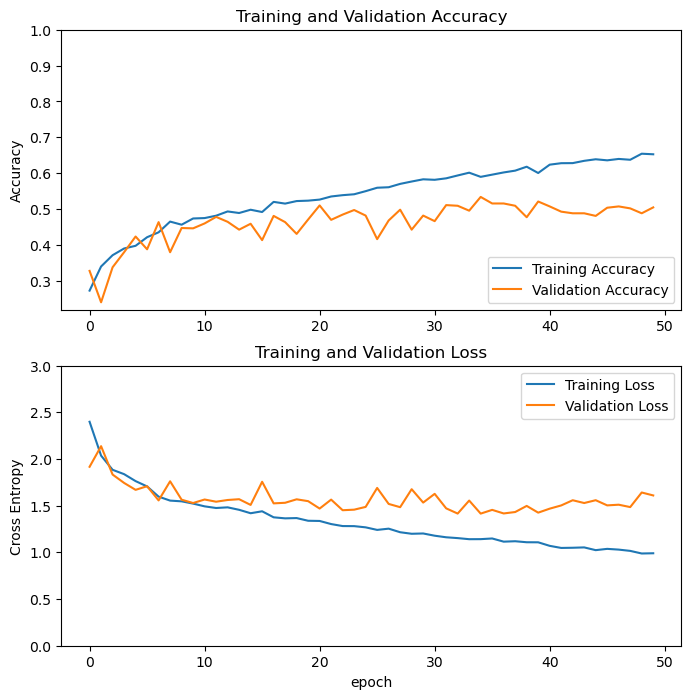

In [16]:
# Show the learning curves of the training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

13/13 [==============================] - 0s 32ms/step - loss: 1.7199 - accuracy: 0.4712
Test accuracy : 0.4711538553237915
pred [[1.0559372e-01 2.3592052e-05 4.2789859e-05 8.3787352e-01 3.5403717e-02
  7.9647516e-04 8.5696875e-04 1.9409208e-02 9.0651958e-11]
 [3.1548381e-01 1.3104036e-03 1.8617589e-02 3.0297530e-01 4.2050902e-02
  1.6961291e-01 4.5141168e-02 1.0480798e-01 1.6636696e-08]
 [6.6730320e-01 2.0894760e-03 3.3539757e-02 1.7320973e-01 8.6807601e-02
  1.2946730e-02 1.3908939e-02 1.0194526e-02 1.0215526e-08]
 [9.3580496e-01 1.7594029e-03 3.2484459e-03 3.3108180e-03 2.6440058e-02
  1.2371518e-02 4.7960499e-04 1.6585190e-02 5.3943183e-10]
 [2.5627276e-01 1.8873872e-02 2.5827708e-03 5.9377449e-03 2.4971021e-03
  7.0777851e-01 3.2380703e-03 2.8191018e-03 1.2326797e-09]
 [3.5357516e-02 4.8504546e-03 1.1043932e-02 1.1099953e-02 3.5354465e-02
  8.2326823e-01 6.5766543e-02 1.3258838e-02 3.2097557e-08]
 [5.4348743e-01 4.4736460e-02 3.4181315e-03 7.1317814e-03 2.4697812e-01
  1.0887299e-0

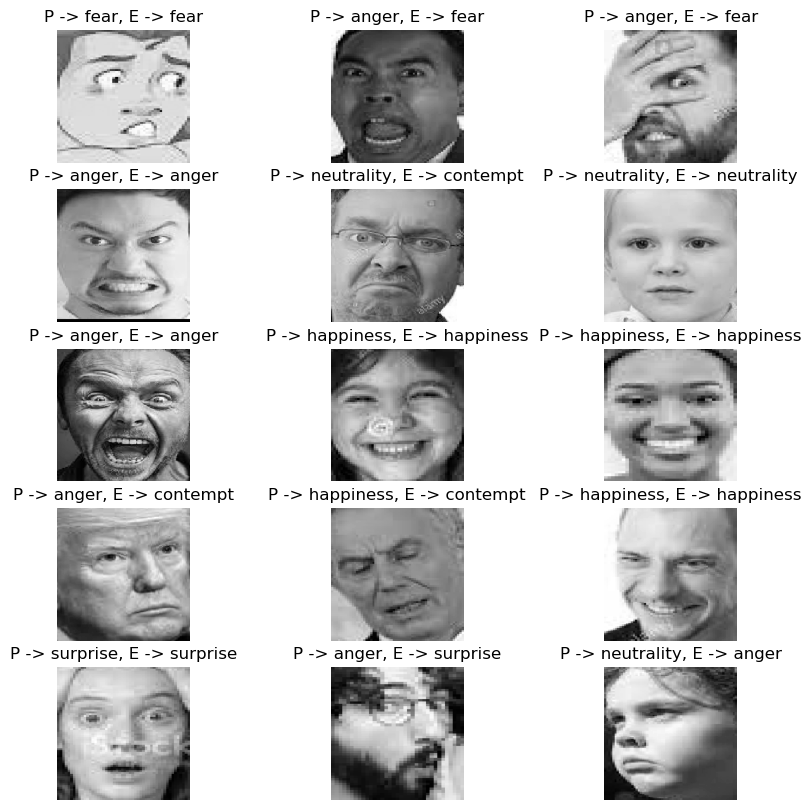

In [21]:
# Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print('pred', predictions)


# Apply a sigmoid since our model returns logits
predicted_class = np.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_class)
print('Labels:\n', label_batch)
print('Classes:\n', class_names)
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"), cmap='gray')
    plt.title('P -> {}, E -> {}'.format(class_names[predicted_class[i]], class_names[label_batch[i]]))
    plt.axis("off")